In [37]:
import os, sys, warnings
import cfgrib

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

In [38]:
#/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/archive/20180124/models/gfs0p25
gfs_dir = '/uufs/chpc.utah.edu/common/home/u1070830/mewessler/archive/'

#/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/iso/199508
era_dir = '/uufs/chpc.utah.edu/common/home/u1070830/mewessler/era5/'

### Sample a single grid from each first to see variables/units

In [20]:
test_date = datetime(2018, 1, 1, 0)

gfs_date_dir = gfs_dir + test_date.strftime('%Y%m%d/')

gfs_idx_flist = gfs_flist = glob(gfs_date_dir + '*/gfs0p25/*.%s.*.WE.grib2.*.idx'%test_date.strftime('%Y%m%d%H'))
[os.remove(f) for f in gfs_idx_flist]

gfs_flist = sorted(glob(gfs_date_dir + '*/gfs0p25/*.%s.*.WE.grib2'%test_date.strftime('%Y%m%d%H')))
gfs_test_file = gfs_flist[1]; gfs_test_file

'/uufs/chpc.utah.edu/common/home/u1070830/mewessler/archive/20180101/models/gfs0p25/gfs.0p25.2018010100.f003.WE.grib2'

In [33]:
gfs_test = []
for gfs_test_file in gfs_flist:

    gfs_test.append(xr.open_dataset(gfs_test_file, engine='cfgrib', 
                    backend_kwargs={'errors':'ignore', 
                                    'filter_by_keys':{'typeOfLevel': 'isobaricInhPa'}}))

gfs_test = xr.concat(gfs_test, dim='valid_time').drop('time').rename({'valid_time':'time', 'gh':'z', 'isobaricInhPa':'level'})
gfs_test.attrs = {}

era_date_dir = era_dir + test_date.strftime('iso/%Y%m/')
era_flist = sorted(glob(era_date_dir + '*%s*.WE.nc'%test_date.strftime('%Y%m%d%H')))

era_test = xr.open_mfdataset(era_flist)
era_test.attrs = {}
era_test = era_test.rename({k:k.lower() for k in era_test.keys()})

overlap_keys = [k for k in era_test.data_vars if k in gfs_test.data_vars]
overlap_times = [t for t in era_test.time.values if t in gfs_test.time.values]
overlap_levels = [l for l in era_test.level.values if l in gfs_test.level.values]

gfs_test = gfs_test.sel(time=overlap_times, level=overlap_levels)
era_test = era_test[overlap_keys].sel(time=overlap_times, level=overlap_levels)

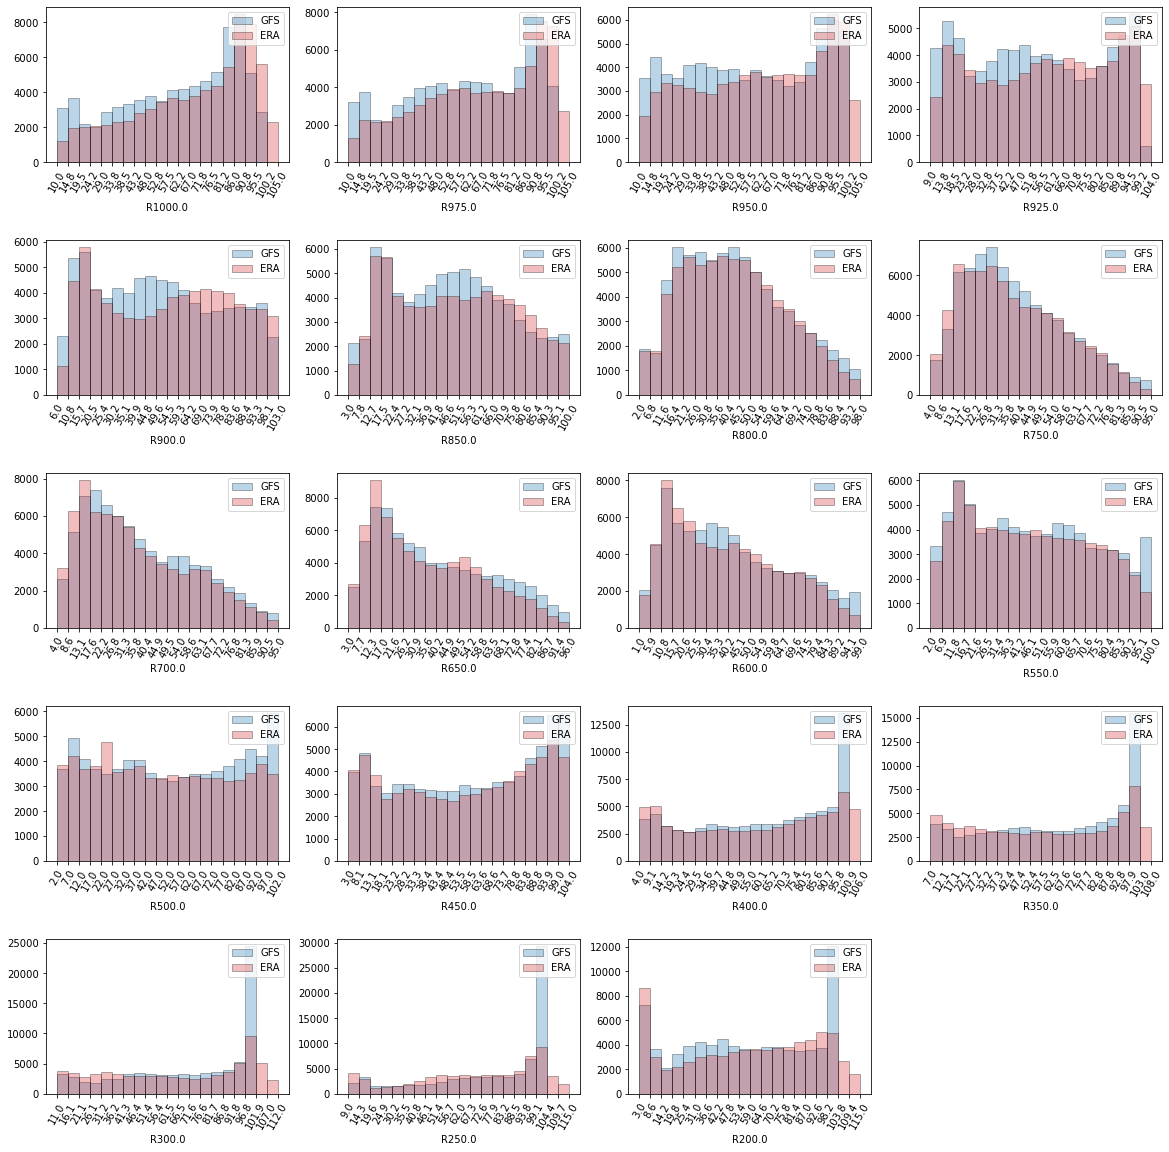

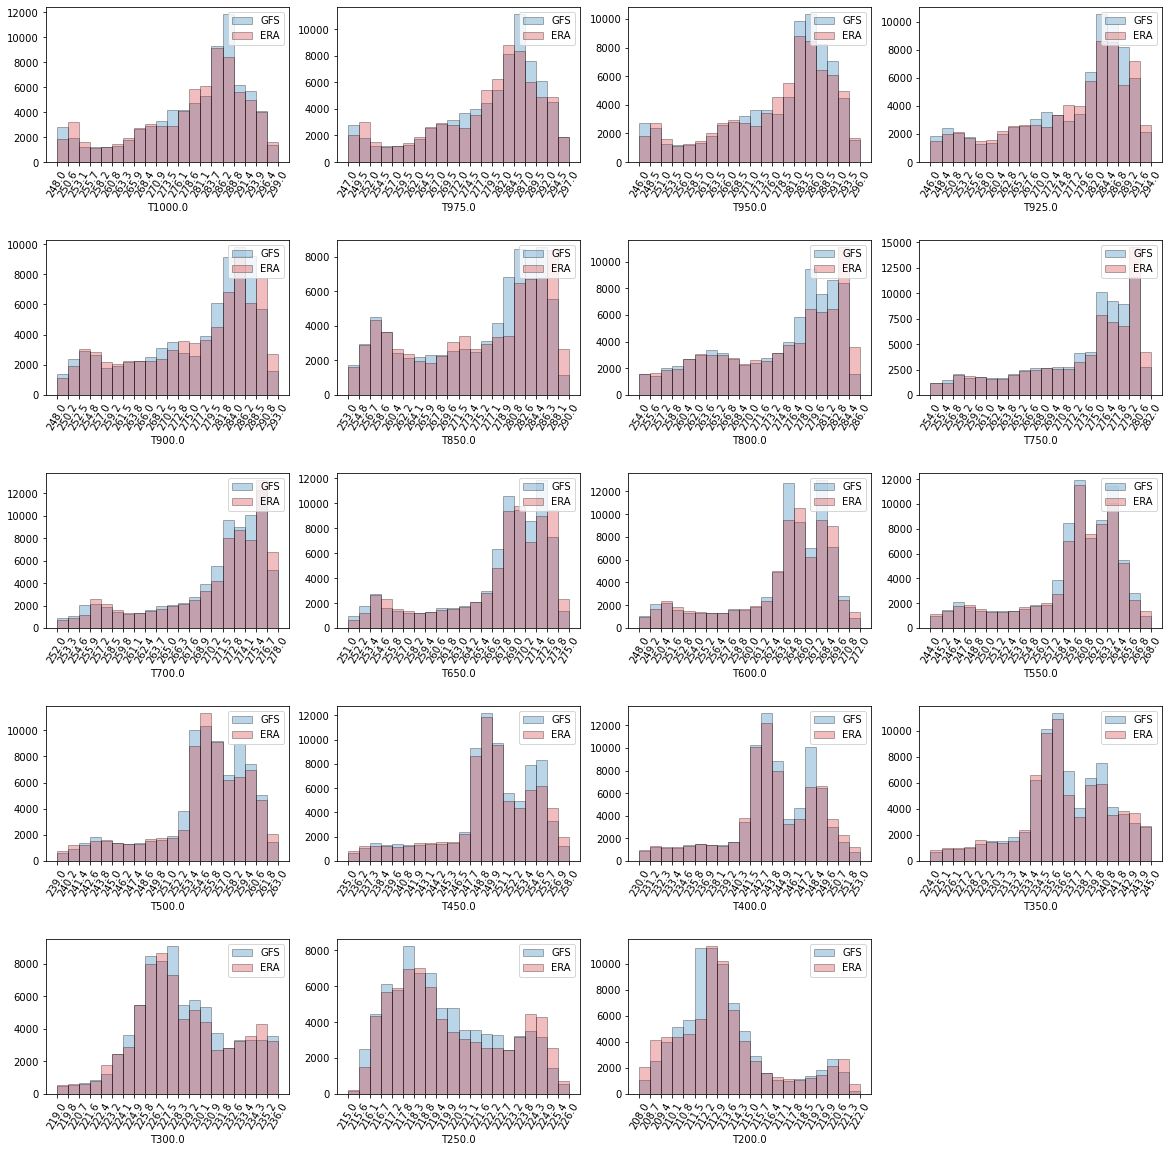

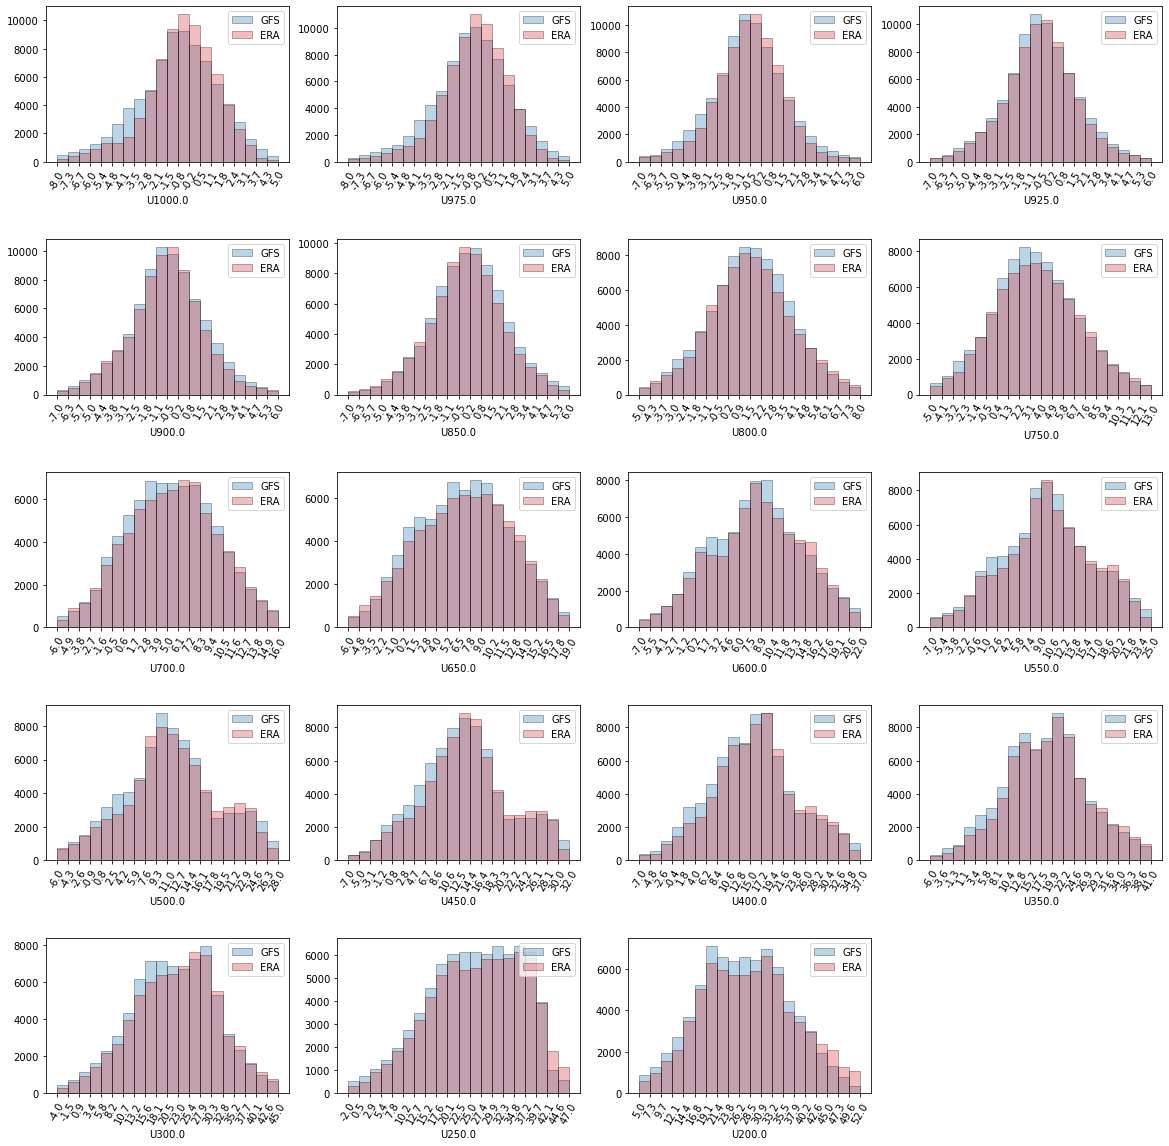

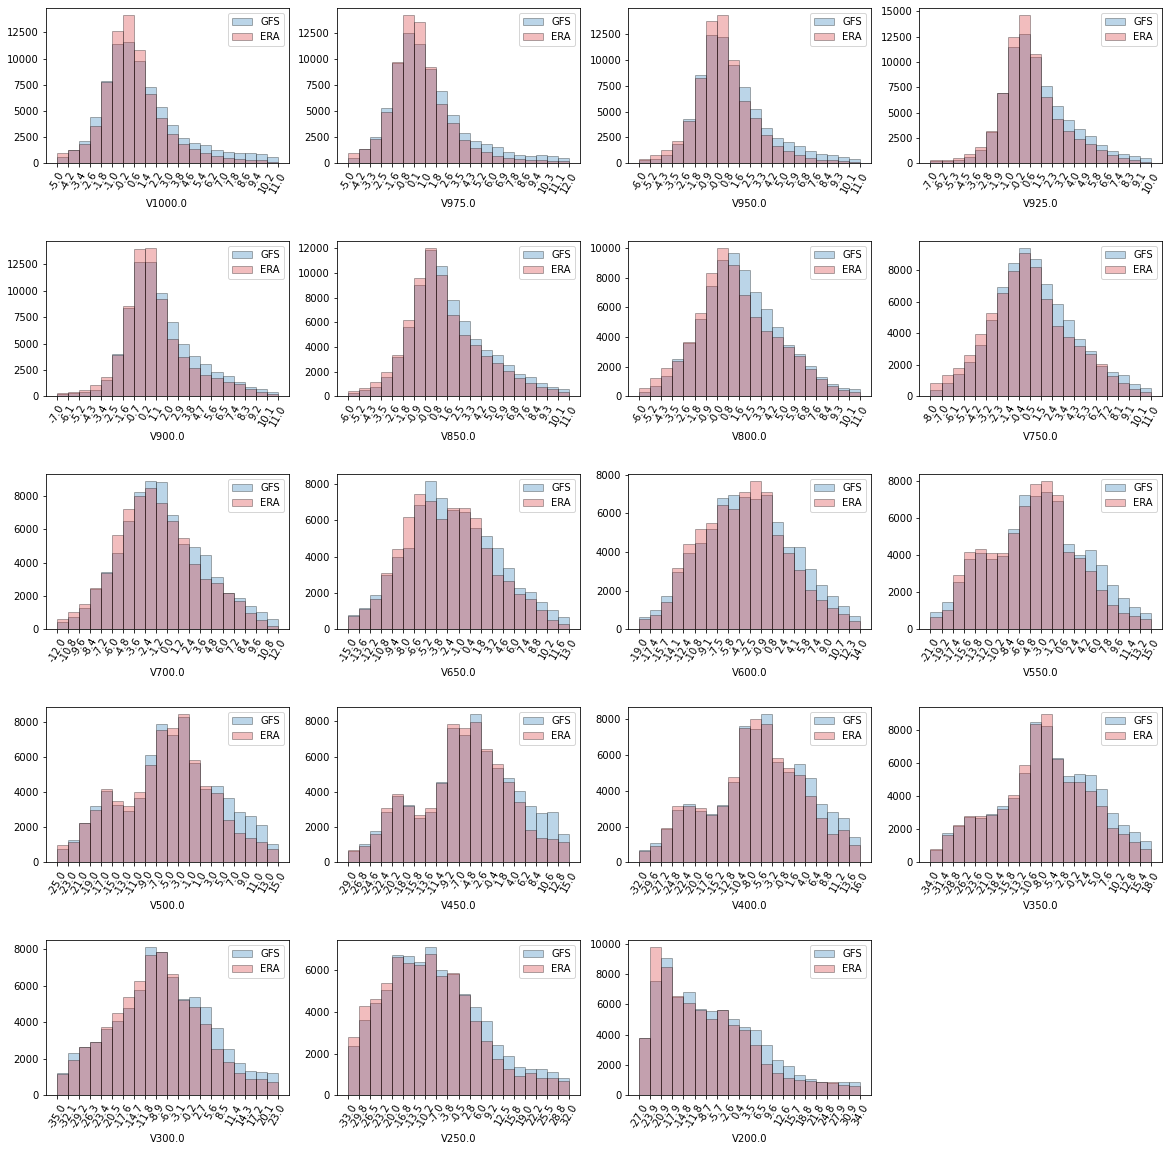

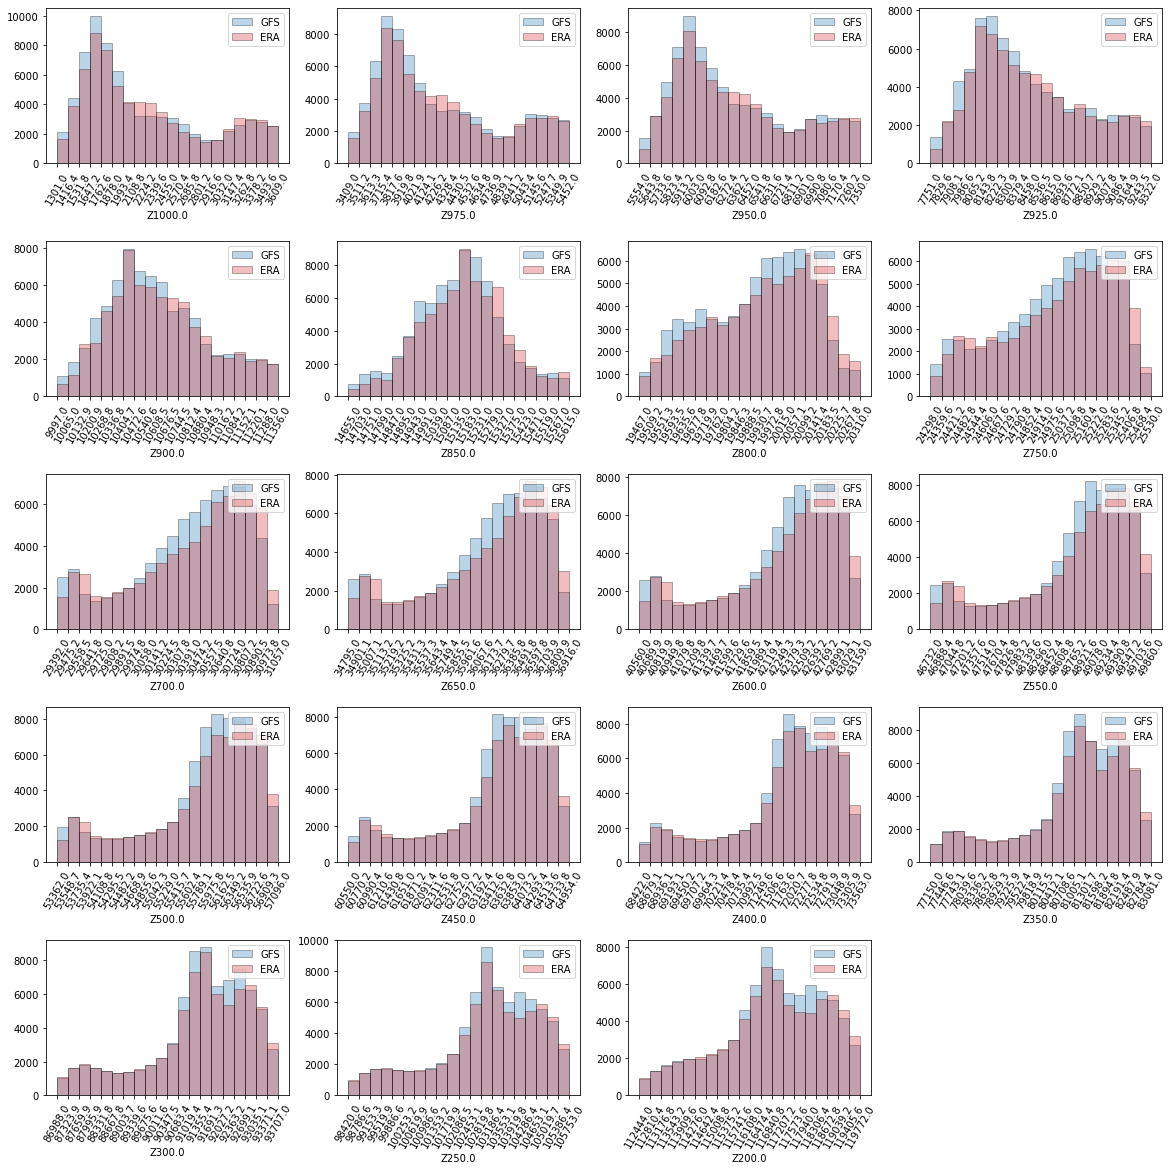

In [113]:
scale_factors = {'z':9.81, 'r':1}

for k in overlap_keys:
    
    try:
        factor = scale_factors[k]
    except KeyError:
        factor = 1.
    
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5)
    
    axs = axs.flatten()
    
#     minval, maxval = np.percentile(
#         np.append(gfs_test[k].values.flatten(),
#         era_test[k].sel(level=level).values.flatten()),
#         [1, 99])
    
#     bins = np.linspace(np.floor(minval), np.ceil(maxval), 21)
    
    for ax, level in zip(axs[:-1], overlap_levels[::-1]):
        
        gfs_vals = gfs_test[k].sel(level=level).values.flatten()*factor
        era_vals = era_test[k].sel(level=level).values.flatten()
        
        minval, maxval = np.percentile(np.append(gfs_vals, era_vals), [1, 99])
        bins = np.linspace(np.floor(minval), np.ceil(maxval), 21)
        
        hist_args = dict(
            bins=bins,
            edgecolor='k',
            alpha=0.3,)
        
        ax.hist(gfs_vals, color='C0', label='GFS', **hist_args)
        ax.hist(era_vals, color='C3', label='ERA', **hist_args)

        ax.set_xticks(bins)
        ax.set_xticklabels(['%.1f'%b for b in bins], rotation=60)
        ax.set_xlabel(k.upper() + str(level))
        
        ax.legend(loc='upper right')
    
    axs[-1].axis('off')
    plt.show()